In [1]:
pip install pandas pybiomart seaborn matplotlib SigProfilerMatrixGenerator SigProfilerAssignment

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Ensure plots are shown inline in the notebook

import matplotlib.pyplot as plt
%matplotlib inline


# Update the font cache
# Path to the Arial font file
from matplotlib import font_manager
font_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Arial.ttf'
font_manager.fontManager.addfont(font_path)
# Set default font to Arial and minimum font size to 12
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

In [2]:
# https://useast.ensembl.org/info/genome/variation/prediction/predicted_data.html

In [2]:
def check_for_gene(dict, gene):
    # Step 1: Combine all dataframes into a single dataframe
    combined_df = pd.concat(dict.values(), keys=dict.keys(), names=['Sample'])
    combined_df = combined_df.reset_index(level='Sample')
    
    # Step 2: Filter for oncogenes
    all_genes = combined_df['Gene Symbol'].unique()

    return gene in all_genes

In [3]:
import pandas as pd

def read_vep_output(file_path):
    with open(file_path, 'r') as file:
        # Skip lines until the header is found
        for line in file:
            if line.startswith('#') and not line.startswith('##'):
                header = line[1:].strip().split('\t')  # Remove '#' and split the header
                break

    # Read the file into a pandas DataFrame, using the header found above
    df = pd.read_csv(file_path, comment='#', sep='\t', names=header, header=None)
    

    return df

In [8]:
import os

folder_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Mutect2/tumor_vs_liver_AF_5_DP_10'


dataframe_dict = {}

original_shapes = {}

for subfolder in os.listdir(folder_path):
    if subfolder.endswith('liver'):
        vep_path = os.path.join(folder_path, subfolder, subfolder + ".mutect2.txt")
        vep_df = read_vep_output(vep_path)
        dataframe_dict[subfolder] = vep_df
        original_shapes[subfolder] = vep_df.shape
    else:
        continue

original_shapes

{'tumor_vs_liver': (371637, 14)}

In [9]:
def filter_vep_output(df):
    # Ensure the columns 'Gene' and 'Extra' exist in the DataFrame
    if 'Gene' not in df.columns or 'Extra' not in df.columns:
        raise ValueError("DataFrame must contain 'Gene' and 'Extra' columns.")
    
    # Filter for gene IDs that start with 'ENS'
    ens_filter = df['Gene'].str.startswith('ENS')
    
    # Filter for 'Extra' column containing 'IMPACT=HIGH' or 'IMPACT=MODERATE'
    high_impact_filter = df['Extra'].str.contains('IMPACT=HIGH')
    moderate_impact_filter = df['Extra'].str.contains('IMPACT=MODERATE')
    
    # Combine filters with correct grouping
    filtered_df = df[ens_filter & (high_impact_filter | moderate_impact_filter)]
    # filtered_df = df[ens_filter]
    
    return filtered_df


In [10]:
filtered_dataframe_dict = {}
filtered_shapes = {}

for key, item in dataframe_dict.items():
    filtered_df = filter_vep_output(item)
    filtered_dataframe_dict[key] = filtered_df
    filtered_shapes[key] = filtered_df.shape

print(filtered_shapes)


{'tumor_vs_liver': (2130, 14)}


In [11]:
gene = "ENSMUSG00000019768" #ESR1
column = "Gene"

for key, df in filtered_dataframe_dict.items():
    # Subset the dataframe to rows where the "Gene" column matches the requested gene
    subset = df.loc[df[column] == gene]
    
    # Check if there are any matching rows
    if not subset.empty:
        print(f"Matches found in {key}:")
        print(subset)
    else:
        print(f"No matches found in {key}")
        

No matches found in tumor_vs_liver


In [9]:
from pybiomart import Dataset
import pandas as pd

def find_homologs(gene_ids):
    try:
        # Load the Ensembl dataset for mouse genes
        mouse_dataset = Dataset(name='mmusculus_gene_ensembl', host='http://www.ensembl.org')
        # print(mouse_dataset.head(10))
        
        # Query the dataset for homologs of the rat gene using 'gene_id' filter
        result = mouse_dataset.query(attributes=[
            'ensembl_gene_id', 
            'hsapiens_homolog_ensembl_gene'
        ], filters={'link_ensembl_gene_id': gene_ids})
       
        # If no homologs are found, return an empty DataFrame
        if not result.empty:
            return result
        else:
            print("result empty")
            return pd.DataFrame()  # Return empty DataFrame if no results found
     
    except Exception as e:
        print(f"Error finding homologs: {e}")
        return pd.DataFrame()  # Return empty DataFrame in case of an error

In [10]:
import sys


def chunk_list(lst, chunk_size):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]


homolog_dict = {}

for key, item in filtered_dataframe_dict.items():
    gene_ids = item["Gene"].tolist()

    
    # Initialize an empty dataframe to store the results
    all_results = pd.DataFrame()

    # Process each chunk of gene_ids
    for chunk in chunk_list(gene_ids, 200):
        results = find_homologs(chunk)
        all_results = pd.concat([all_results, results], ignore_index=True)
    
    # Merge the dataframes on the gene identifiers
    item = item.merge(all_results, left_on='Gene', right_on='Gene stable ID', how='left')
    
    # Rename the columns to match your desired output
    item.rename(columns={'Human gene stable ID': 'Homologs'}, inplace=True)
    
    # Drop the extra column if you don't need it
    item.drop(columns=['Gene stable ID'], inplace=True)


    item = item[item['Homologs'].notna()]
    homolog_dict[key] = item



In [11]:
from pybiomart import Dataset

def find_symbols(ensembl_ids):
    try:
        # Load the Ensembl dataset for human genes

        dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
        result = dataset.query(attributes=['ensembl_gene_id','external_gene_name', ],
                              filters={'link_ensembl_gene_id': ensembl_ids})

        # Extract the homolog gene IDs if they exist
        if not result.empty:
            return result
    except Exception as e:
        print(f"Error finding GeneSymbols for {ensembl_ids}: {e}")
    return ensembl_ids, None



In [12]:
import sys

def chunk_list(lst, chunk_size):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

symbol_dict = {}

for key, item in homolog_dict.items():
    ensembl_ids = item["Homologs"].tolist()


    # Initialize an empty dataframe to store the results
    all_results = pd.DataFrame()

    # Process each chunk of gene_ids
    for chunk in chunk_list(ensembl_ids, 200):
        results = find_symbols(chunk)
        all_results = pd.concat([all_results, results], ignore_index=True)
    
    # Merge the dataframes on the gene identifiers
    item = item.merge(all_results, left_on='Homologs', right_on='Gene stable ID', how='left')
    
    # Rename the columns to match your desired output
    item.rename(columns={'Gene name': 'Gene Symbol'}, inplace=True)

    # Drop the extra column if you don't need it
    item.drop(columns=['Gene stable ID'], inplace=True)


    item = item[item['Gene Symbol'].notna()]
    symbol_dict[key] = item


In [13]:
print(symbol_dict)

{'tumor_vs_liver':                                      Uploaded_variation  \
0                     10_7473269_-/ACAGACAGACAGACAGACAG   
1                     10_7473269_-/ACAGACAGACAGACAGACAG   
2                     10_7473269_-/ACAGACAGACAGACAGACAG   
3                     10_7473269_-/ACAGACAGACAGACAGACAG   
4                     10_7473269_-/ACAGACAGACAGACAGACAG   
...                                                 ...   
1917  X_153153310_-/AATAACTTTGCATCTGATGTCAATGAGTTAGT...   
1918                                  X_153499477_ACC/-   
1919                                  X_159414733_GGC/-   
1920                                  X_159988452_GCG/-   
1921                                    X_164423401_-/T   

                   Location  \
0        10:7473268-7473269   
1        10:7473268-7473269   
2        10:7473268-7473269   
3        10:7473268-7473269   
4        10:7473268-7473269   
...                     ...   
1917  X:153153309-153153310   
1918  X:153499477-153499

In [14]:
gene = "KDM6A"
column = "Gene Symbol"

for key, df in symbol_dict.items():
    # Subset the dataframe to rows where the "Gene" column matches the requested gene
    subset = df.loc[df[column] == gene]
    
    # Check if there are any matching rows
    if not subset.empty:
        print(f"Matches found in {key}:")
        print(subset)
    else:
        print(f"No matches found in {key}")


Matches found in tumor_vs_liver:
     Uploaded_variation             Location Allele                Gene  \
1876   X_18163034_CCG/-  X:18163034-18163036      -  ENSMUSG00000037369   
1877   X_18163034_CCG/-  X:18163034-18163036      -  ENSMUSG00000037369   
1878   X_18163034_CCG/-  X:18163034-18163036      -  ENSMUSG00000037369   

                 Feature Feature_type  \
1876  ENSMUST00000044484   Transcript   
1877  ENSMUST00000052368   Transcript   
1878  ENSMUST00000223885   Transcript   

                                  Consequence cDNA_position CDS_position  \
1876                         inframe_deletion       460-462        29-31   
1877                         inframe_deletion       460-462        29-31   
1878  inframe_deletion,NMD_transcript_variant       392-394        29-31   

     Protein_position Amino_acids      Codons Existing_variation  \
1876            10-11        TA/T  aCCGcc/acc                  -   
1877            10-11        TA/T  aCCGcc/acc               

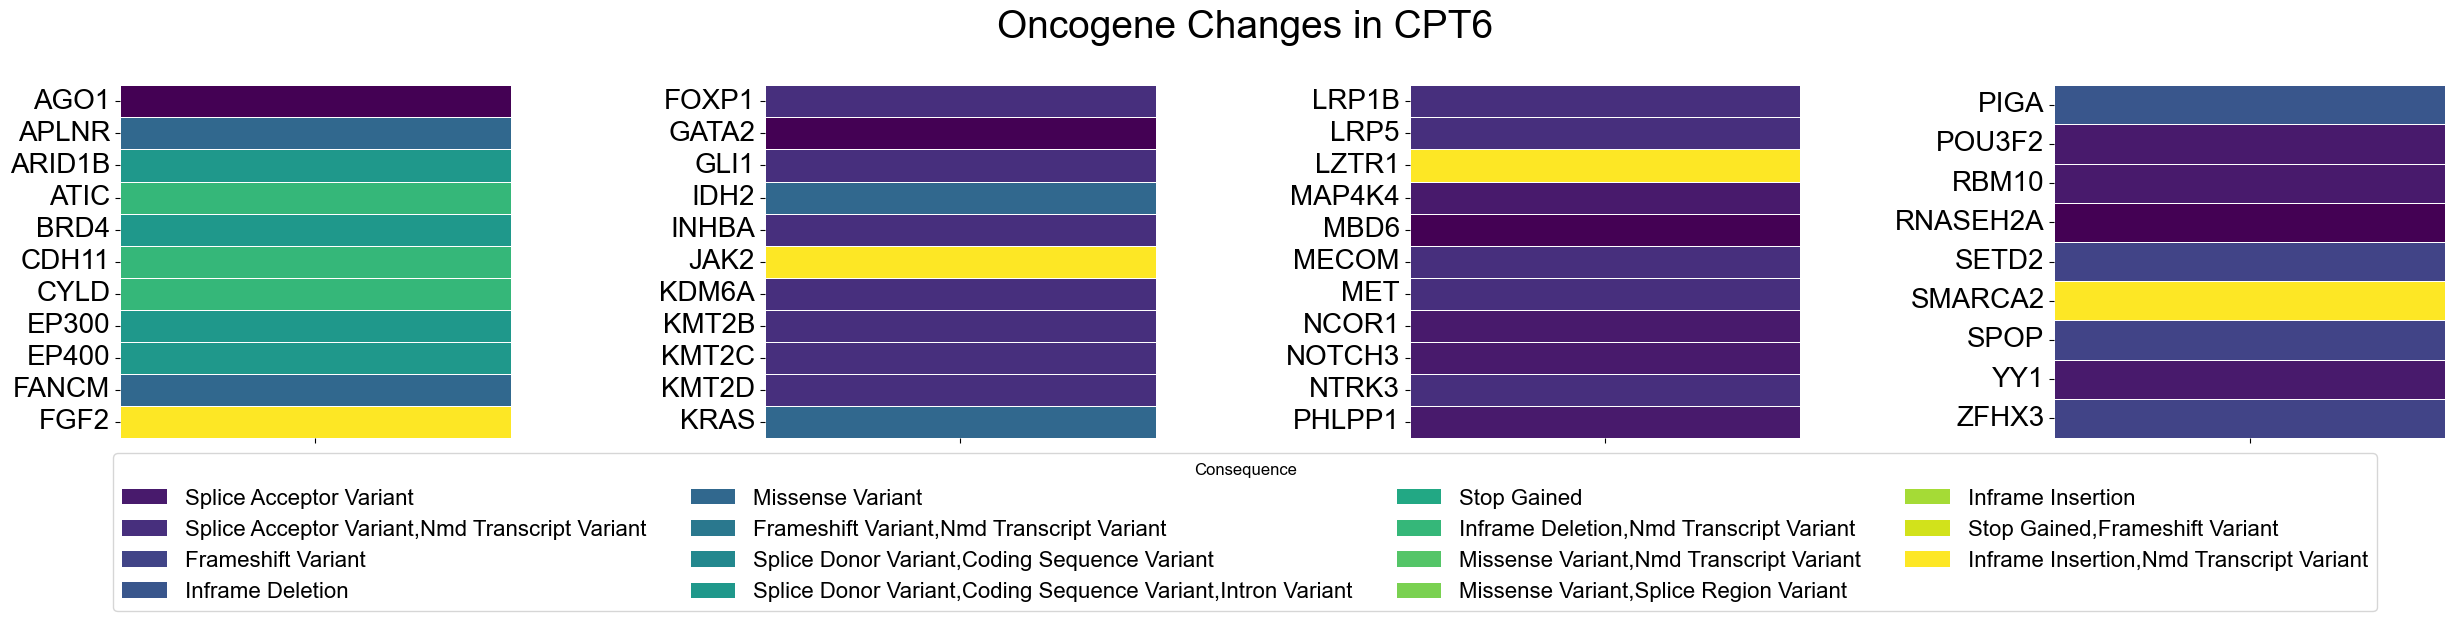

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
import os

# Update the font cache
# Path to the Arial font file
from matplotlib import font_manager
font_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Arial.ttf'
font_manager.fontManager.addfont(font_path)
# Set default font to Arial and minimum font size to 12
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# Function to classify genes using the OncoKB database
def classify_genes_oncokb(gene_list, oncokb_df):
    tsg_list = oncokb_df[oncokb_df['Is Tumor Suppressor Gene'] == 'Yes']['Hugo Symbol'].tolist()
    oncogene_list = oncokb_df[oncokb_df['Is Oncogene'] == 'Yes']['Hugo Symbol'].tolist()

    tsgs = [gene for gene in gene_list if gene in tsg_list]
    oncogenes = [gene for gene in gene_list if gene in oncogene_list]
    return tsgs + oncogenes

def classify_genes_brca(gene_list, brca_df):
    brca_list = brca_df['Gene'].tolist()
    genes = [gene for gene in gene_list if gene in brca_list]
    return genes

MODE = "ONCOKB"  # Can be "BRCA" or "ONCOKB"

# Assuming symbol_dict is already defined with sample_ids as keys and VEP output dataframes as values
if 'symbol_dict' not in globals():
    raise ValueError("symbol_dict is not defined.")

# Load the OncoKB database file
file_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/cancerGeneList.tsv'
oncokb_df = pd.read_csv(file_path, sep='\t')

brca_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/brca_genelist.csv'
brca_df = pd.read_csv(brca_path)

# Step 1: Combine all dataframes into a single dataframe
combined_df = pd.concat(symbol_dict.values(), keys=symbol_dict.keys(), names=['Sample'])
combined_df = combined_df.reset_index(level='Sample')

# Ensure necessary columns exist
if 'Gene Symbol' not in combined_df.columns or 'Extra' not in combined_df.columns:
    raise ValueError("combined_df must contain 'Gene Symbol' and 'Extra' columns.")

# Step 2: Filter for oncogenes
all_genes = combined_df['Gene Symbol'].unique()

if MODE == "ONCOKB":
    oncogenes = classify_genes_oncokb(all_genes, oncokb_df)
elif MODE == "BRCA":
    oncogenes = classify_genes_brca(all_genes, brca_df)

combined_df = combined_df[combined_df['Gene Symbol'].isin(oncogenes)]

# Step 3: Prepare data for plotting
# Extract IMPACT from the Extra column
combined_df['IMPACT'] = combined_df['Extra'].str.extract(r'IMPACT=([^;]+)')

# Sort by IMPACT, giving priority to 'HIGH' over 'MODERATE'
impact_priority = {'HIGH': 1, 'MODERATE': 2}
combined_df['IMPACT_PRIORITY'] = combined_df['IMPACT'].map(impact_priority)
combined_df = combined_df.sort_values(by=['Sample', 'Gene Symbol', 'IMPACT_PRIORITY'])

# Custom aggregation function to pick the most common consequence for each gene in each sample
def most_common_consequence(sub_df):
    return sub_df.sort_values(by='IMPACT_PRIORITY').iloc[0]

# Apply the custom aggregation function
agg_df = combined_df.groupby(['Sample', 'Gene Symbol'], as_index=False, group_keys=False).apply(most_common_consequence)
agg_df.loc[agg_df['Gene Symbol'] == 'KRAS', 'Consequence'] = 'missense_variant'
agg_df.loc[agg_df['Gene Symbol'] == 'JAK2', 'Consequence'] = 'stop_gained'

# Check if agg_df is correctly generated
if agg_df.empty:
    raise ValueError("agg_df is empty. Check your aggregation logic.")

# Create a pivot table
plot_data = agg_df.pivot_table(values='Consequence', index='Gene Symbol', columns='Sample', aggfunc='first')

# Step 4: Sort genes alphabetically
plot_data = plot_data.sort_index()

# Step 5: Create a mapping of consequences to numbers for color-coding
unique_consequences = combined_df['Consequence'].unique()
consequence_map = {cons: i+1 for i, cons in enumerate(unique_consequences)}  # Start from 1 instead of 0

# Replace consequences with their corresponding numbers
plot_data_numeric = plot_data.applymap(lambda x: consequence_map.get(x, 0))  # Use 0 for missing values

# Split genes into four columns
num_genes = len(plot_data_numeric)
chunk_size = num_genes // 4 + (num_genes % 4 > 0)  # Divide into four chunks
plot_data_chunks = [
    plot_data_numeric.iloc[i * chunk_size: (i + 1) * chunk_size, :]
    for i in range(4)
]

# Adjust figure height based on the number of genes
fig_height = max(num_genes * 0.1, 2)  # Decrease the height scaling factor for smaller boxes

# Plot the four columns side by side
fig, axs = plt.subplots(1, 4, figsize=(30, fig_height))  # Adjust the width for four columns

# Plot each column
for i, ax in enumerate(axs):
    sns.heatmap(plot_data_chunks[i], cmap=ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(unique_consequences) + 1))), cbar=False, ax=ax, linewidths=0.5)
    sns.color_palette("tab20", len(unique_consequences))
    ax.set_ylabel('')  # Only the first subplot gets a y-axis label
    ax.set_xlabel('')

# Adjust y-ticks for all plots
for ax in axs:
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=20)
    ax.set_xticklabels([])

# Add a legend for the consequences
legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(unique_consequences) + 1)))(consequence_map[cons] / (len(unique_consequences) + 1)), 
                                 edgecolor='none', label=cons.replace('_', ' ').title()) for cons in unique_consequences]
fig.legend(handles=legend_elements, title='Consequence', bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=4, prop={'size': 16})

# Add title for the plot
fig.suptitle('Oncogene Changes in CPT6', fontsize=28, fontweight='bold')  # Add title

# Adjust spacing between the plots
plt.subplots_adjust(wspace=0.65, bottom=-0.04, top=0.8)

# Save the new plot
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"oncoplot_split_{MODE}.png")
plt.savefig(output_file, format='png')

plt.show()# Sort genes by the most common consequence type

In [29]:
print("Number of genes: ", num_genes)

Number of genes:  42


In [15]:
agg_df.to_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/agg.csv", index=False)

In [16]:
import pandas as pd

# Load the provided CSV file
file_path = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/agg.csv"
df = pd.read_csv(file_path)

# Ensure the relevant columns exist
required_columns = {'Consequence', 'IMPACT_PRIORITY', 'Gene Symbol'}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

# Regroup and sort the dataframe based on the given criteria
df_sorted = df.sort_values(by=['Consequence', 'IMPACT_PRIORITY', 'Gene Symbol'], ascending=[True, True, True])

print(df_sorted)
df_sorted.to_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/agg_sorted.csv", index=False)

                     Sample  \
1   filtered_tumor_vs_liver   
9   filtered_tumor_vs_liver   
12  filtered_tumor_vs_liver   
26  filtered_tumor_vs_liver   
36  filtered_tumor_vs_liver   
33  filtered_tumor_vs_liver   
2   filtered_tumor_vs_liver   
4   filtered_tumor_vs_liver   
7   filtered_tumor_vs_liver   
8   filtered_tumor_vs_liver   
11  filtered_tumor_vs_liver   
13  filtered_tumor_vs_liver   
15  filtered_tumor_vs_liver   
17  filtered_tumor_vs_liver   
18  filtered_tumor_vs_liver   
19  filtered_tumor_vs_liver   
20  filtered_tumor_vs_liver   
25  filtered_tumor_vs_liver   
29  filtered_tumor_vs_liver   
30  filtered_tumor_vs_liver   
32  filtered_tumor_vs_liver   
34  filtered_tumor_vs_liver   
35  filtered_tumor_vs_liver   
40  filtered_tumor_vs_liver   
38  filtered_tumor_vs_liver   
3   filtered_tumor_vs_liver   
5   filtered_tumor_vs_liver   
6   filtered_tumor_vs_liver   
14  filtered_tumor_vs_liver   
21  filtered_tumor_vs_liver   
22  filtered_tumor_vs_liver   
23  filt

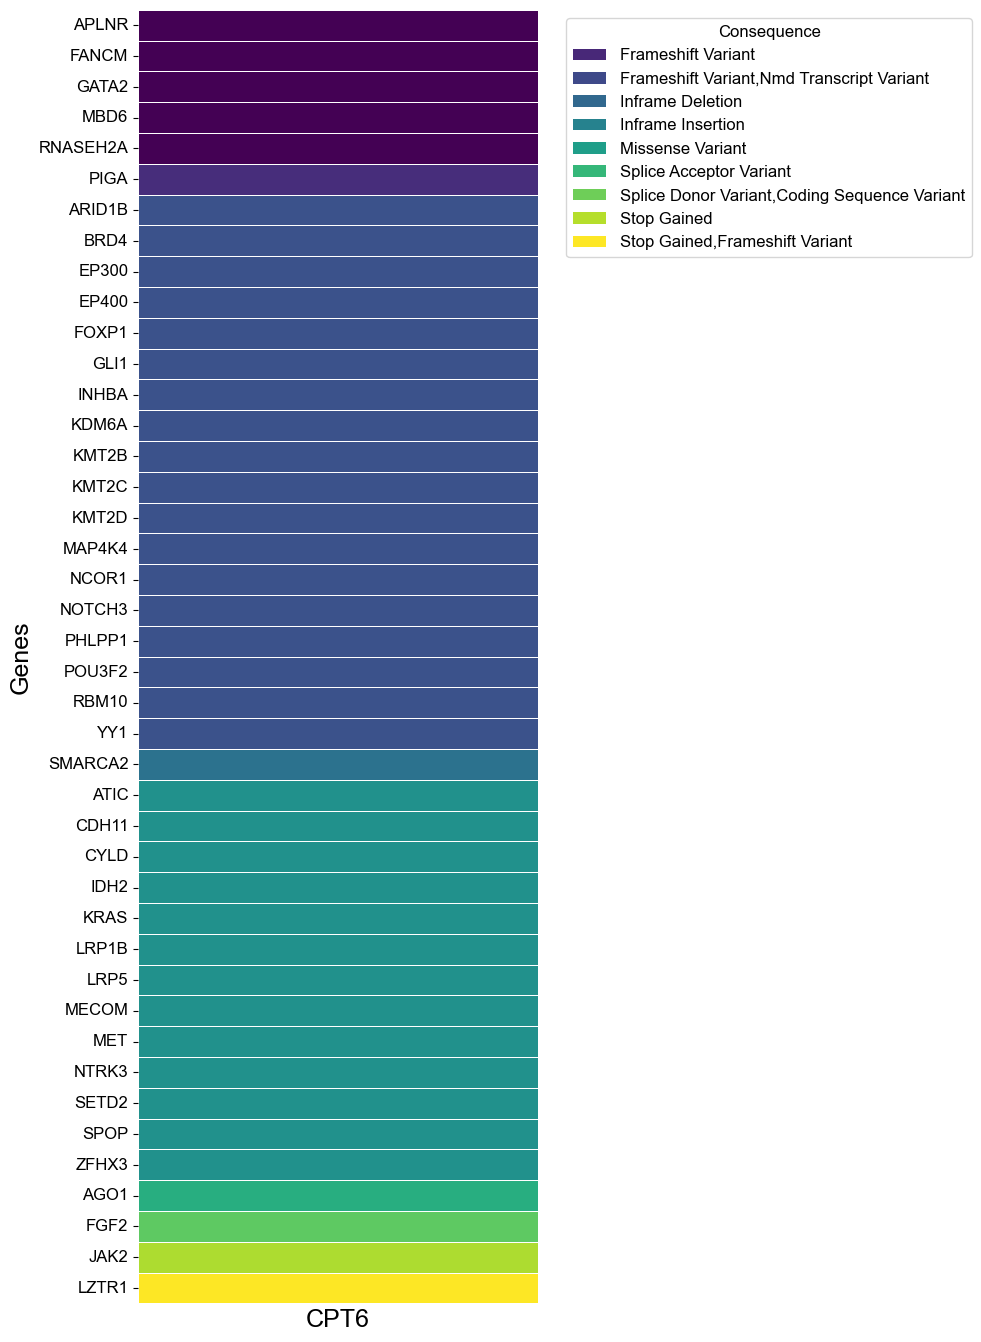

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
import pandas as pd

# Sample data setup (Ensure df_sorted is defined beforehand)
# df_sorted should be a preprocessed dataframe containing 'Consequence_Numeric', 'Gene Symbol', and 'Sample'

# Define a colormap using viridis
unique_consequences = df_sorted['Consequence'].unique()
consequence_map = {cons: i+1 for i, cons in enumerate(unique_consequences)}  # Start from 1 instead of 0

# Replace consequences with their corresponding numbers
df_sorted['Consequence_Numeric'] = df_sorted['Consequence'].map(consequence_map)

# Maintain the original order of df_sorted
df_sorted = df_sorted.reset_index(drop=True)

# Create pivot table for heatmap while preserving order
df_sorted['Index'] = df_sorted.index  # Assign an index to preserve order
plot_data = df_sorted.pivot_table(values='Consequence_Numeric', index='Index', columns='Sample', aggfunc='first')

# Remove rows where all values are NaN to avoid blank spaces
plot_data_filtered = plot_data.dropna(how='all')

# Adjust figure height based on the filtered data
fig_height_filtered = max(plot_data_filtered.shape[0] * 0.4, 6)

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, fig_height_filtered))
custom_cmap = sns.color_palette("viridis", as_cmap=True)
sns.heatmap(plot_data_filtered, cmap=custom_cmap, cbar=False, linewidths=0.5, ax=ax)  # Removed colorbar and annotations

# Set labels and formatting
plt.ylabel('Genes', fontsize=18)
plt.xlabel('CPT6', fontsize=18)  # Changed x-axis label
plt.xticks([], [])  # Hide x-ticks

# Adjust y-axis ticks for better readability
ax.set_yticks(np.arange(len(plot_data_filtered.index)) + 0.5)  # Center y-ticks
ax.set_yticklabels(df_sorted.loc[plot_data_filtered.index, 'Gene Symbol'], fontsize=12, rotation=0, ha="right", va="center")

# Create a custom legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=plt.cm.viridis(consequence_map[cons]/len(unique_consequences)), 
                                 edgecolor='none', label=cons.replace('_', ' ').title()) for cons in unique_consequences]
plt.legend(handles=legend_elements, title='Consequence', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

# Improve spacing between y-axis labels
plt.subplots_adjust(left=0.4)  # Increase left margin to better position labels

# Show the plot
plt.show()


In [18]:
# Count the number of genes in each consequence category
gene_counts = combined_df.groupby("Consequence")['Gene Symbol'].nunique()

# Convert the count data to a DataFrame
gene_counts_df = gene_counts.reset_index()
gene_counts_df.columns = ["Consequence", "Number of Genes"]

# Print the result
print(gene_counts_df)

# Save the counts to a CSV file
output_file = "gene_counts_per_consequence.csv"
gene_counts_df.to_csv(output_file, index=False)
print(f"Gene counts saved to {output_file}")


                                          Consequence  Number of Genes
0                                  frameshift_variant                5
1           frameshift_variant,NMD_transcript_variant                3
2                                    inframe_deletion               19
3             inframe_deletion,NMD_transcript_variant                1
4                                   inframe_insertion                4
5            inframe_insertion,NMD_transcript_variant                1
6                                    missense_variant               14
7             missense_variant,NMD_transcript_variant                4
8              missense_variant,splice_region_variant                1
9                             splice_acceptor_variant                1
10     splice_acceptor_variant,NMD_transcript_variant                1
11       splice_donor_variant,coding_sequence_variant                1
12  splice_donor_variant,coding_sequence_variant,i...                1
13    

/scratch/slurm-5146953/ipykernel_54635/1251590526.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_cmap = cm.get_cmap("viridis")


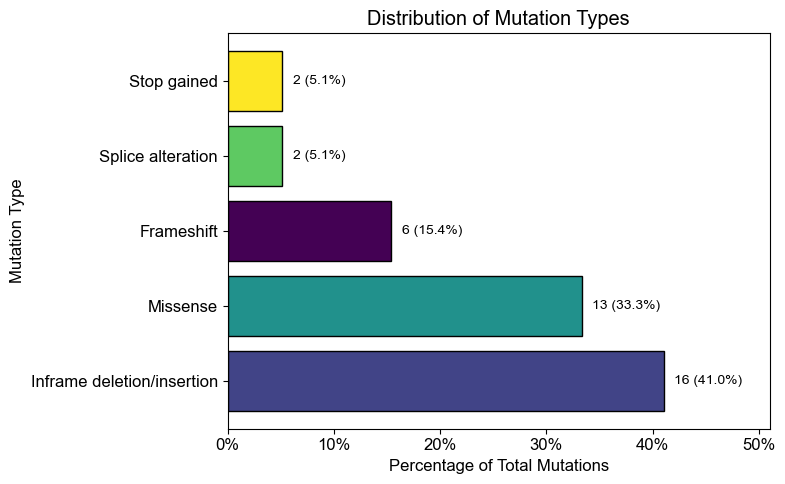

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.cm as cm

# Update the font cache
# Path to the Arial font file
from matplotlib import font_manager
font_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Arial.ttf'
font_manager.fontManager.addfont(font_path)
# Set default font to Arial and minimum font size to 12
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# Data
mutation_types_switched = [
    "Inframe deletion/insertion",
    "Missense",
    "Frameshift",
    "Splice alteration",
    "Stop gained", 
]

counts_switched = np.array([16, 13, 6, 2, 2])  # Adjusted order accordingly
total = counts_switched.sum()
percentages_switched = (counts_switched / total) * 100

# Define viridis colormap
viridis_cmap = cm.get_cmap("viridis")

# Original color mapping before switching positions
original_order = [
    "Inframe deletion/insertion",
    "Missense",
    "Frameshift",
    "Splice alteration",
    "Stop gained"
]
color_map = {
    "Inframe deletion/insertion": viridis_cmap(0.2),  # Dark blue
    "Missense": viridis_cmap(0.5),  # Light blue
    "Frameshift": viridis_cmap(0.0),  # Purple
}

# Assign colors for each mutation type, keeping the original color assignments
color_dict = {mutation: color_map.get(mutation, viridis_cmap(i / (len(original_order) - 1))) 
              for i, mutation in enumerate(original_order)}
colors_switched = [color_dict[mutation] for mutation in mutation_types_switched]

# Plot with switched bars but original colors
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(mutation_types_switched, percentages_switched, color=colors_switched, edgecolor='black')

# Annotate with exact numbers
for bar, count, percent in zip(bars, counts_switched, percentages_switched):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f"{count} ({percent:.1f}%)",
            va='center', fontsize=10)

# Labels and formatting
ax.set_xlabel("Percentage of Total Mutations")
ax.set_ylabel("Mutation Type")
ax.set_xlim(0, max(percentages_switched) + 10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

# Title
ax.set_title("Distribution of Mutation Types")

# Show plot
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# Load BED file (ensure columns are chromosome, start, end)
bed_df = pd.read_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/reference/Twist_Mouse_Exome_Target_Rev1_GRCm38.bed", sep="\t", header=None, names=["chrom", "start", "end"])

# Calculate total base pairs
total_bases = (bed_df["end"] - bed_df["start"]).sum()

# Convert to megabases
total_megabases = total_bases / 1e6
print(f"Total covered region: {total_megabases} Mb")

Total covered region: 37.679879 Mb


                     Sample  Total Count       TMB
0   filtered_tumor_vs_liver         2130  7.213004
21  filtered_tumor_vs_liver         2130  7.213004
23  filtered_tumor_vs_liver         2130  7.213004
24  filtered_tumor_vs_liver         2130  7.213004
25  filtered_tumor_vs_liver         2130  7.213004
26  filtered_tumor_vs_liver         2130  7.213004
27  filtered_tumor_vs_liver         2130  7.213004
28  filtered_tumor_vs_liver         2130  7.213004
29  filtered_tumor_vs_liver         2130  7.213004
30  filtered_tumor_vs_liver         2130  7.213004
31  filtered_tumor_vs_liver         2130  7.213004
32  filtered_tumor_vs_liver         2130  7.213004
33  filtered_tumor_vs_liver         2130  7.213004
34  filtered_tumor_vs_liver         2130  7.213004
35  filtered_tumor_vs_liver         2130  7.213004
36  filtered_tumor_vs_liver         2130  7.213004
37  filtered_tumor_vs_liver         2130  7.213004
38  filtered_tumor_vs_liver         2130  7.213004
39  filtered_tumor_vs_liver    

KeyError: 'tumor_vs_liver'

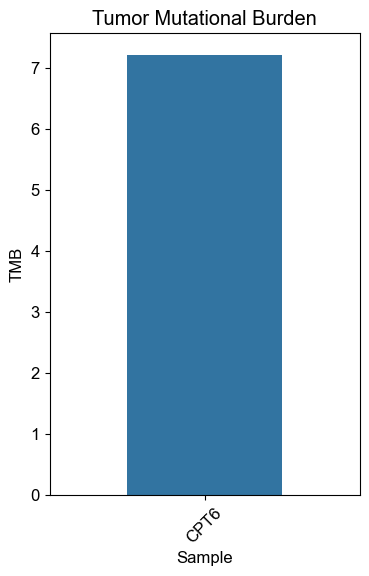

In [23]:
## import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# Foley, J.F., Phadke, D.P., Hardy, O. et al. Whole exome sequencing in the rat. BMC Genomics 19, 487 (2018). https://doi.org/10.1186/s12864-018-4858-8
def calculate_tmb(df, mb_covered=295.3):  
    return len(df) / mb_covered

# Calculate TMB and total counts for each sample
tmb_dict = {}
total_counts = {}
for sample, df in filtered_dataframe_dict.items():
    tmb = calculate_tmb(df)
    total_count = len(df)
    tmb_dict[sample] = tmb
    total_counts[sample] = total_count

# # Sort samples by total count (descending order)
# sorted_samples = sorted(total_counts.items(), key=lambda x: x[1], reverse=False)
# sample_order = [sample for sample, _ in sorted_samples]

# Prepare data for plotting
plot_data = []
for sample, _ in filtered_dataframe_dict.items():
    df = filtered_dataframe_dict[sample]
    consequences = df['Consequence'].value_counts()
    for consequence, count in consequences.items():
        plot_data.append({
            'Sample': sample,
#            'Consequence': consequence,
            'Total Count': total_counts[sample],
            'TMB': tmb_dict[sample]
        })

plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.loc[plot_df['Sample'].sort_values(ascending=False).index]

print(plot_df)

# Create a thick bar plot for each tumor
plt.figure(figsize=(4, 6))
ax = sns.barplot(x='Sample', y='TMB', width=0.2, data=plot_df, )

# Adjust x-axis width
plt.xlim(-0.2, 0.2)

# Customize the plot
plt.title('Tumor Mutational Burden')
plt.xlabel('Sample')
plt.ylabel('TMB')
plt.xticks(rotation=45)

ax.set_xticklabels(['CPT6'])

samples = ['tumor_vs_liver']

# Add TMB values on top of each bar

for i, sample in enumerate(samples):
    tmb = tmb_dict[sample]
    total_count = total_counts[sample]
    ax.text(i, tmb , f'TMB: {tmb:.2f}', ha='center', va='bottom')


# Modify x-axis labels
current_labels = plt.gca().get_xticklabels()
num_labels = len(current_labels)

# Create new labels
new_labels = ['CPT6']

plt.gca().set_xticklabels(new_labels)
plt.xlabel('Samples')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()

# Save the plot as an SVG file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "tmb.svg")
plt.savefig(output_file, format='svg')


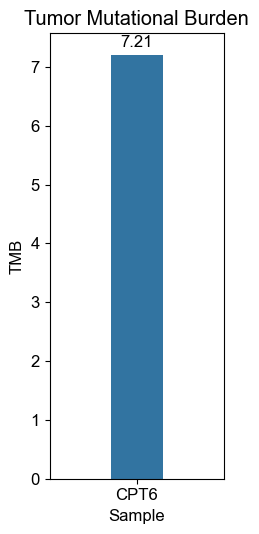

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
plot_df = pd.DataFrame({
    'Sample': ['CPT6'],
    'TMB': [7.21]
})

plt.figure(figsize=(2.5, 5.5))  # Make the figure narrower so the bar occupies more space
ax = sns.barplot(x='Sample', y='TMB', data=plot_df, width=0.3)  # Increase width for a thicker bar

# If there's only one sample, manually set x-ticks and labels
ax.set_xticks([0])
ax.set_xticklabels(['CPT6'])

# Adjust the x-axis limits to reduce blank space around the single bar
# Here, we center the bar around 0 and limit the width to 1 unit total
ax.set_xlim(-0.5, 0.5)

# Annotate the exact TMB value on top of the bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # offset from top of bar
                textcoords="offset points",
                ha='center', va='bottom')

# Customize axes labels and title
plt.title('Tumor Mutational Burden')
plt.xlabel('Sample')
plt.ylabel('TMB')

# Reduce any extra whitespace
plt.tight_layout()

# Save or display the plot
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "tmb.svg")
plt.savefig(output_file, format='svg')
plt.show()


In [25]:
print(tmb)

56.49867374005304


In [1]:
import SigProfilerMatrixGenerator
from SigProfilerMatrixGenerator import install as genInstall

In [2]:
genInstall.install('mm10')

Tool       | Installed 
-----------------------
curl       | True      
wget       | True      
rsync      | True      


INFO - mm10 is already installed.


All reference files have been created.
To proceed with matrix_generation, please provide the path to your vcf files and an appropriate output path.
Installation complete.


In [3]:
# Path to the input somatic mutations file (if using segmentation file/mutational matrix) or input folder (mutation calling file/s).
samples = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CPT6_Mutect2_VCF_Input/filtered/"
# Path to the output folder.
output = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CPT6_SigProfilerAssignmentOutput/filtered/"

In [4]:
import SigProfilerAssignment as spa
from SigProfilerAssignment import Analyzer as Analyze


Analyze.cosmic_fit(samples=samples, 
                   output=output,
                   input_type="vcf",
                   context_type="96",
                   genome_build="mm10",
                   cosmic_version=3.4)

Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 4.73 seconds.
Completed! Elapsed time: 4.56 seconds...
Matrices generated for 1 samples with 3550 errors. Total of 7468 SNVs, 195 DINUCs, and 6871 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 1/1 [100%] in 1.6s (0.63/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


                         SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  SBS7a  SBS7b  \
Samples                                                                     
filtered_tumor_vs_liver   279     0     0     0  5304   719      0      0   

                         SBS7c  SBS7d  ...  SBS90  SBS91  SBS92  SBS93  SBS94  \
Samples                                ...                                      
filtered_tumor_vs_liver      0      0  ...      0      0      0      0      0   

                         SBS95  SBS96  SBS97  SBS98  SBS99  
Samples                                                     
filtered_tumor_vs_liver      0      0      0      0      0  

[1 rows x 86 columns]
Plot saved as output_plots/sigprofiler.svg


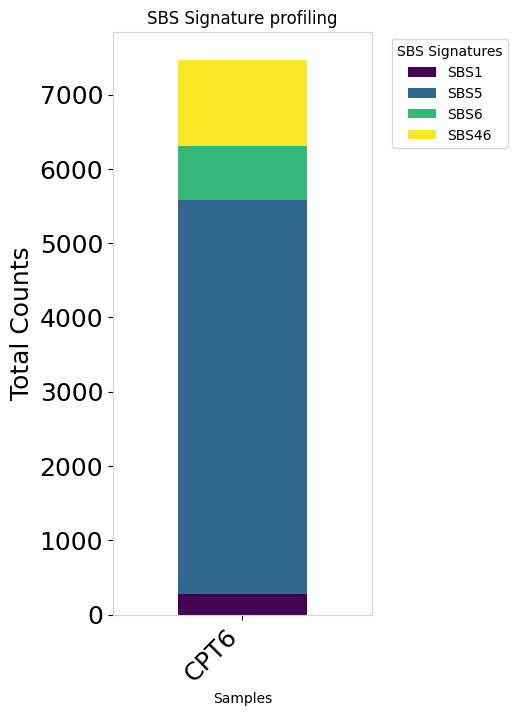

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

def plot_sbs_signatures(file_path):
    # Read the file into a DataFrame
    try:
        df = pd.read_csv(file_path, sep='\t')
    except Exception as e:
        print(f"Error reading the file: {e}")
        return
    
    # Check if DataFrame is correctly loaded
    if df.empty:
        print("DataFrame is empty. Please check the file content.")
        return

    # Set 'Samples' column as the index
    df.set_index('Samples', inplace=True)

    df = df.sort_index(ascending=False)
    print(df)
    # Drop columns where all values are zero
    df = df.loc[:, (df != 0).any(axis=0)]

    ax = df.plot(kind='bar', stacked=True, figsize=(6, 8), colormap='viridis')
    ax.set_ylabel('Total Counts', fontsize = 18)
    # ax.set_title('SBS Signature Counts per Sample')
    plt.legend(title='SBS Signatures', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    # Modify x-axis labels
    current_labels = plt.gca().get_xticklabels()
    num_labels = len(current_labels)
    
    # Create new labels
    new_labels = ['CPT6']
    plt.gca().set_xticklabels(new_labels, fontsize = 18)
    # Increase y-tick label font size
    plt.yticks(fontsize=18)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=18)

    # Add title to the plot
    plt.title('SBS Signature profiling')

    # Save the plot as an SVG file
    output_dir = "output_plots"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "sigprofiler.svg")
    plt.savefig(output_file, format='svg')
    
    print(f"Plot saved as {output_file}")

# Path to the output folder.
output = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CPT6_SigProfilerAssignmentOutput/filtered"

# Example usage
file_path = os.path.join(output, 'Assignment_Solution/Activities/Assignment_Solution_Activities.txt')

plot_sbs_signatures(file_path)

In [12]:
genInstall.install('hg38')

INFO - Downloading hg38...


Tool       | Installed 
-----------------------
curl       | True      
wget       | True      
rsync      | True      


INFO - Attempt to download from alexandrovlab failed: 550 Could not get file size.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (78) The file does not exist
ERROR - Curl download failed with error: Command '['curl', '-o', '/ihome/alee/dal413/.local/lib/python3.10/site-packages/SigProfilerMatrixGenerator/references/chromosomes/tsb/hg38.tar.gz', 'ftp://alexandrovlab-ftp.ucsd.edu/pub/tools/SigProfilerMatrixGenerator//hg38.tar.gz']' returned non-zero exit status 78..
ERROR - Curl download failed with error: Command '['curl', '-o', '/ihome/alee/dal413/.local/lib/python3.10/site-packages/SigProfilerMatrixGenerator/references/chromosomes/tsb/hg38.tar.gz', 'ftp://alexandrovlab-ftp.ucsd.edu/pub/tools/SigProfilerMatrixGenerator//hg38.tar.gz']' returned non-zero exit status 78.
INFO - Attempt to downlo

FileNotFoundError: [Errno 2] No such file or directory: '/ihome/alee/dal413/.local/lib/python3.10/site-packages/SigProfilerMatrixGenerator/references/chromosomes/tsb/hg38.tar.gz'

In [22]:
from SigProfilerMatrixGenerator import install as genInstall

genInstall.install('GRCh38', rsync=False, bash=True)

Tool       | Installed 
-----------------------
curl       | True      
wget       | True      
rsync      | True      


INFO - GRCh38 is already installed.


All reference files have been created.
To proceed with matrix_generation, please provide the path to your vcf files and an appropriate output path.
Installation complete.


In [23]:
# Path to the input somatic mutations file (if using segmentation file/mutational matrix) or input folder (mutation calling file/s).
samples = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CPT6_Mutect2_VCF_Input/ICLE/"
# Path to the output folder.
output = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CPT6_SigProfilerAssignmentOutput/ICLE/"

In [19]:
import subprocess

# This command installs the hg38 genome for SigProfilerMatrixGenerator:
subprocess.run(["python", "-m", "SigProfilerMatrixGenerator.install", "hg38"])


CompletedProcess(args=['python', '-m', 'SigProfilerMatrixGenerator.install', 'hg38'], returncode=0)

In [25]:
pip install --upgrade SigProfilerMatrixGenerator

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [26]:
import SigProfilerAssignment as spa
from SigProfilerAssignment import Analyzer as Analyze


Analyze.cosmic_fit(samples=samples, 
                   output=output,
                   input_type="vcf",
                   context_type="96",
                   genome_build="hg38",
                   cosmic_version=3.4)

ERROR - No checksum information available for hg38.


Exception: The specified genome hg38 has not been installed
Please refer to the SigProfilerMatrixGenerator README for installation instructions:
	https://github.com/AlexandrovLab/SigProfilerMatrixGenerator

In [25]:
import pandas as pd

human_tmb_df = pd.read_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/TMB_Human_Lawrence_2013.csv")

human_tmb_df_exome = human_tmb_df[human_tmb_df['datatype'] == 'exome']

print(human_tmb_df_exome)


mean_exome_tmb = human_tmb_df['coding_mutation_rate'].mean()
print(mean_exome_tmb*(10**6))

    tumor_type        name datatype  n_coding_mutations  coding_mutation_rate  \
5       Breast     BR-0007    exome                  20          6.670000e-07   
9       Breast     BR-0011    exome                  23          7.670000e-07   
10      Breast     BR-0012    exome                  35          1.170000e-06   
11      Breast     BR-0013    exome                  25          8.330000e-07   
12      Breast     BR-0014    exome                  70          2.330000e-06   
..         ...         ...      ...                 ...                   ...   
113     Breast  BR-MEX-186    exome                  31          1.030000e-06   
114     Breast  BR-MEX-189    exome                  63          2.100000e-06   
115     Breast  BR-MEX-191    exome                 268          8.930000e-06   
116     Breast  BR-MEX-192    exome                  30          1.000000e-06   
117     Breast  BR-MEX-193    exome                  74          2.470000e-06   

     n_CtoT  n_CtoA  n_CtoG

In [ ]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import os
import matplotlib
# Set the backend to a non-interactive one
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the output folders
cpt6_output = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CPT6_SigProfilerAssignmentOutput/filtered"
icle_output = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CPT6_SigProfilerAssignmentOutput/ICLE"

# File paths for the activity files
cpt6_file_path = os.path.join(cpt6_output, 'Assignment_Solution/Activities/Assignment_Solution_Activities.txt')
icle_file_path = os.path.join(icle_output, 'Assignment_Solution/Activities/Assignment_Solution_Activities.txt')

# Read the files into DataFrames
cpt6_df = pd.read_csv(cpt6_file_path, sep='\t')
icle_df = pd.read_csv(icle_file_path, sep='\t')

# Set 'Samples' column as the index
cpt6_df.set_index('Samples', inplace=True)
icle_df.set_index('Samples', inplace=True)

# Rename the CPT6 sample (remove genome annotation)
cpt6_df.index = ['CPT6']

# Calculate the mean of ICLE samples and rename without genome build annotation
icle_mean = pd.DataFrame(icle_df.mean(axis=0)).T
icle_mean.index = ['ICLE']

# Combine the two DataFrames
combined_df = pd.concat([cpt6_df, icle_mean])

# Drop columns where all values are zero
combined_df = combined_df.loc[:, (combined_df != 0).any(axis=0)]

# Sort columns by total contribution
column_sums = combined_df.sum()
sorted_columns = column_sums.sort_values(ascending=False).index.tolist()
combined_df = combined_df[sorted_columns]

# Keep only top 10 signatures for clarity
if len(combined_df.columns) > 10:
    top_signatures = sorted_columns[:10]
    other_signatures = sorted_columns[10:]
    
    # Sum the remaining signatures into an "Other" category
    combined_df['Other'] = combined_df[other_signatures].sum(axis=1)
    combined_df = combined_df[top_signatures + ['Other']]

# Calculate percentages for each row
combined_df_percent = combined_df.div(combined_df.sum(axis=1), axis=0) * 100

# Create a figure with two subplots - one for counts and one for percentages
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Generate a distinct discrete color palette based on the number of signatures
colors_combined = sns.color_palette("tab20", n_colors=len(combined_df.columns))

# Plot raw counts using discrete colors
combined_df.plot(kind='bar', stacked=True, ax=ax1, color=colors_combined)
ax1.set_ylabel('Mutation Counts', fontsize=18)
ax1.set_title('SBS Signature Counts Comparison', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(title='SBS Signatures', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Plot percentages using the same discrete colors
combined_df_percent.plot(kind='bar', stacked=True, ax=ax2, color=colors_combined)
ax2.set_ylabel('Percentage (%)', fontsize=18)
ax2.set_title('SBS Signature Percentage Comparison', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.legend(title='SBS Signatures', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Rotate x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.03, 0.85, 0.98])

# Create output directory if it doesn't exist
output_dir = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/ICLE/maftools/output_plots"
os.makedirs(output_dir, exist_ok=True)

# Save the combined plots in multiple formats
plt.savefig(os.path.join(output_dir, "combined_signatures.pdf"), format='pdf')
plt.savefig(os.path.join(output_dir, "combined_signatures.svg"), format='svg')
plt.savefig(os.path.join(output_dir, "combined_signatures.png"), format='png', dpi=300)

print(f"Combined signature plots saved to {output_dir}")

# Create a more detailed version with individual ICLE samples (without genome annotations)
detailed_df = pd.concat([cpt6_df, icle_df])

# Rename the CPT6 sample if necessary
detailed_df = detailed_df.rename(index={'filtered_tumor_vs_liver': 'CPT6'})

# Drop columns where all values are zero
detailed_df = detailed_df.loc[:, (detailed_df != 0).any(axis=0)]

# Sort columns by total contribution
column_sums = detailed_df.sum()
sorted_columns = column_sums.sort_values(ascending=False).index.tolist()
detailed_df = detailed_df[sorted_columns]

# Keep only top 10 signatures for clarity
if len(detailed_df.columns) > 10:
    top_signatures = sorted_columns[:10]
    other_signatures = sorted_columns[10:]
    
    # Sum the remaining signatures into an "Other" category
    detailed_df['Other'] = detailed_df[other_signatures].sum(axis=1)
    detailed_df = detailed_df[top_signatures + ['Other']]

# Calculate percentages for each row
detailed_df_percent = detailed_df.div(detailed_df.sum(axis=1), axis=0) * 100

# Create a figure with two subplots for the detailed view
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(15, 20))

# Generate a discrete color palette for the detailed data
colors_detailed = sns.color_palette("tab20", n_colors=len(detailed_df.columns))

# Plot raw counts for detailed view using distinct colors
detailed_df.plot(kind='bar', stacked=True, ax=ax3, color=colors_detailed)
ax3.set_ylabel('Mutation Counts', fontsize=18)
ax3.set_title('SBS Signature Counts - All Samples', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(title='SBS Signatures', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Plot percentages for detailed view using the same discrete colors
detailed_df_percent.plot(kind='bar', stacked=True, ax=ax4, color=colors_detailed)
ax4.set_ylabel('Percentage (%)', fontsize=18)
ax4.set_title('SBS Signature Percentage - All Samples', fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.legend(title='SBS Signatures', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Rotate x-axis labels for better readability
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 0.85, 0.98])

# Save the detailed plots in multiple formats
plt.savefig(os.path.join(output_dir, "detailed_combined_signatures.pdf"), format='pdf')
plt.savefig(os.path.join(output_dir, "detailed_combined_signatures.svg"), format='svg')
plt.savefig(os.path.join(output_dir, "detailed_combined_signatures.png"), format='png', dpi=300)

print(f"Detailed signature plots saved to {output_dir}")

# Create a heatmap visualization for better comparison.
# (Note: The heatmap uses a continuous colormap, which is typical for gradient displays.)
plt.figure(figsize=(14, 10))
sns.heatmap(detailed_df_percent, cmap="viridis", annot=True, fmt=".1f", linewidths=.5)
plt.title('SBS Signature Percentage Heatmap', fontsize=20)
plt.ylabel('Samples', fontsize=18)
plt.xlabel('SBS Signatures', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Save the heatmap
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "signature_heatmap.pdf"), format='pdf')
plt.savefig(os.path.join(output_dir, "signature_heatmap.svg"), format='svg')
plt.savefig(os.path.join(output_dir, "signature_heatmap.png"), format='png', dpi=300)

print(f"Signature heatmap saved to {output_dir}")


In [26]:
pip install pyranges gtfparse

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [25]:
import os
import pandas as pd
import pyranges as pr
from gtfparse import read_gtf

# Step 1: Read CNVKit .cns files
def read_cns_file(cns_file):
    cns_data = pd.read_csv(cns_file, sep='\t')
    print(cns_data.head())
    return cns_data

# Step 2: Convert CNVKit data to PyRanges format
def cns_to_pyranges(cns_data):
    cns_data = cns_data.rename(columns={'chromosome': 'Chromosome', 'start': 'Start', 'end': 'End'})
    pr_cns = pr.PyRanges(cns_data)
    return pr_cns

# Step 3: Annotate segments with genes using a GTF file
def annotate_segments_with_genes(pr_cns, gtf_file):
    gtf_data = read_gtf(gtf_file, result_type="pandas")
    gtf_data = gtf_data[gtf_data['feature'] == 'gene']
    gtf_data = gtf_data.rename(columns={'seqname': 'Chromosome', 'start': 'Start', 'end': 'End', 'gene_id': 'Gene'})
    pr_gtf = pr.PyRanges(gtf_data)
    annotated = pr_cns.join(pr_gtf, suffix='_gene')
    return annotated

# Step 4: Filter and summarize the genes with copy number changes
def summarize_gene_changes(annotated_df, sample_name):
    gain_threshold = 0.3
    loss_threshold = -0.3

    annotated_df = annotated_df.df
    print(annotated_df.head())
    
    annotated_df['change'] = annotated_df['log2'].apply(lambda x: 'gain' if x > gain_threshold else 'loss' if x < loss_threshold else 'neutral')
    changed_genes = annotated_df[annotated_df['change'] != 'neutral']

    gene_summary = changed_genes[['Gene', 'change']].drop_duplicates()
    gene_summary = gene_summary.set_index('Gene').rename(columns={'change': sample_name})

    return gene_summary

# Main function to process the files
def process_cns_files(cns_files, gtf_file):
    all_gene_changes = []
    
    for cns_file in cns_files:
        sample_name = os.path.basename(cns_file).split(".")[0]  # Extract sample name from file name
        cns_data = read_cns_file(cns_file)
        pr_cns = cns_to_pyranges(cns_data)
        annotated_df = annotate_segments_with_genes(pr_cns, gtf_file)
        gene_changes = summarize_gene_changes(annotated_df, sample_name)
        all_gene_changes.append(gene_changes)

    combined_gene_changes = pd.concat(all_gene_changes, axis=1).fillna('neutral')
    return combined_gene_changes

# Example usage
cns_files = ["/bgfs/alee/LO_LAB/Personal/Daisong/Sarek/FASTQ2SAREK/wes_result/variant_calling/cnvkit/tumor_vs_liver/tumor.cns"]  # Replace with your actual .cns file paths
gtf_file = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Mus_musculus.GRCm38.102.gtf"  # Replace with the path to your GTF file

gene_changes = process_cns_files(cns_files, gtf_file)
gene_changes.to_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/gene_changes_cns_homo.csv")

  chromosome     start       end gene      log2     depth  probes     weight  \
0          1   3000532  38236527    -  -7.14715  0.656319   26647  11936.000   
1          1  38238394  41331993    -  -8.14855  0.602186    3100   1439.550   
2          1  41334393  42500793    - -10.30260  0.418475     861    396.798   
3          1  42501327  65226123    -  -7.17325  0.651244   17496   7865.190   
4          1  65226123  66189590    -  -4.67091  0.821868     698    323.118   

      ci_lo     ci_hi  
0  -7.19077  -7.09991  
1  -8.24422  -8.00301  
2 -10.58120 -10.04480  
3  -7.22616  -7.12849  
4  -4.88888  -4.28095  


INFO - Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


  Chromosome    Start       End gene     log2     depth  probes   weight  \
0          1  3000532  38236527    - -7.14715  0.656319   26647  11936.0   
1          1  3000532  38236527    - -7.14715  0.656319   26647  11936.0   
2          1  3000532  38236527    - -7.14715  0.656319   26647  11936.0   
3          1  3000532  38236527    - -7.14715  0.656319   26647  11936.0   
4          1  3000532  38236527    - -7.14715  0.656319   26647  11936.0   

     ci_lo    ci_hi  ... havana_transcript havana_transcript_version  tag  \
0 -7.19077 -7.09991  ...                                                    
1 -7.19077 -7.09991  ...                                                    
2 -7.19077 -7.09991  ...                                                    
3 -7.19077 -7.09991  ...                                                    
4 -7.19077 -7.09991  ...                                                    

   transcript_support_level  exon_number exon_id  exon_version ccds_id  \
0     

In [1]:
import os
import pandas as pd
import pyranges as pr
from gtfparse import read_gtf

# Step 1: Read CNVKit .cnr files
def read_cnr_file(cnr_file):
    cnr_data = pd.read_csv(cnr_file, sep='\t', low_memory=False)
    return cnr_data

# Step 2: Convert CNVKit data to PyRanges format
def cnr_to_pyranges(cnr_data):
    cnr_data = cnr_data.rename(columns={'chromosome': 'Chromosome', 'start': 'Start', 'end': 'End'})
    pr_cnr = pr.PyRanges(cnr_data)
    return pr_cnr

# Step 3: Annotate segments with genes using a GTF file
def annotate_segments_with_genes(pr_cnr, gtf_file):
    gtf_data = read_gtf(gtf_file, result_type="pandas")
    gtf_data = gtf_data[gtf_data['feature'] == 'gene']
    gtf_data = gtf_data.rename(columns={'seqname': 'Chromosome', 'start': 'Start', 'end': 'End', 'gene_id': 'Gene'})
    pr_gtf = pr.PyRanges(gtf_data)
    annotated = pr_cnr.join(pr_gtf, suffix='_gene')
    return annotated

# Step 4: Filter and summarize the genes with copy number changes
def summarize_gene_changes(annotated_df, sample_name):
    gain_threshold = 0.3
    loss_threshold = -0.3

    annotated_df = annotated_df.df
    print(annotated_df.head())
    
    annotated_df['change'] = annotated_df['log2'].apply(lambda x: 'gain' if x > gain_threshold else 'loss' if x < loss_threshold else 'neutral')
    changed_genes = annotated_df[annotated_df['change'] != 'neutral']

    gene_summary = changed_genes[['Gene', 'change']].drop_duplicates()
    gene_summary = gene_summary.set_index('Gene').rename(columns={'change': sample_name})

    return gene_summary

# Main function to process the files
def process_cnr_files(cnr_files, gtf_file):
    all_gene_changes = []
    
    for cnr_file in cnr_files:
        sample_name = os.path.basename(cnr_file).split(".")[0]  # Extract sample name from file name
        cnr_data = read_cnr_file(cnr_file)
        pr_cnr = cnr_to_pyranges(cnr_data)
        annotated_df = annotate_segments_with_genes(pr_cnr, gtf_file)
        gene_changes = summarize_gene_changes(annotated_df, sample_name)
        all_gene_changes.append(gene_changes)

    combined_gene_changes = pd.concat(all_gene_changes, axis=1).fillna('neutral')
    return combined_gene_changes

# Example usage
cnr_files = ["/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/B6ILC-cellsrg.mkdp.cnr"]  # Replace with your actual .cnr file paths
gtf_file = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Mus_musculus.GRCm38.102.gtf"  # Replace with the path to your GTF file

gene_changes = process_cnr_files(cnr_files, gtf_file)
gene_changes.to_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/gene_changes_cnr.csv")

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


Empty DataFrame
Columns: []
Index: []


KeyError: 'log2'

In [27]:
import os
import pandas as pd
import pyranges as pr
from gtfparse import read_gtf

# Step 1: Read CNVKit .cnr files
def read_cnr_file(cnr_file):
    cnr_data = pd.read_csv(cnr_file, sep='\t', low_memory=False)
    return cnr_data

# Step 2: Convert CNVKit data to PyRanges format
def cnr_to_pyranges(cnr_data):
    cnr_data = cnr_data.rename(columns={'chromosome': 'Chromosome', 'start': 'Start', 'end': 'End'})
    pr_cnr = pr.PyRanges(cnr_data)
    return pr_cnr

# Step 3: Annotate segments with genes using a GTF file
def annotate_segments_with_genes(pr_cnr, gtf_file):
    gtf_data = read_gtf(gtf_file, result_type="pandas")
    gtf_data = gtf_data[gtf_data['feature'] == 'gene']
    gtf_data = gtf_data.rename(columns={'seqname': 'Chromosome', 'start': 'Start', 'end': 'End', 'gene_id': 'Gene'})
    pr_gtf = pr.PyRanges(gtf_data)
    annotated = pr_cnr.join(pr_gtf, suffix='_gene')
    return annotated

# Step 4: Filter and summarize the genes with significant copy number changes
def summarize_gene_changes(annotated_df, sample_name):
    # Extract annotated dataframe from PyRanges
    annotated_df = annotated_df.df

    # Define thresholds for significant changes
    gain_threshold = 1
    loss_threshold = -1

    # Filter out genes with log2 ratios between -0.3 and 0.3 (neutral range)
    significant_changes = annotated_df[(annotated_df['log2'] > gain_threshold) | (annotated_df['log2'] < loss_threshold)]

    # Summarize log2 ratios for each gene
    gene_summary = significant_changes[['Gene', 'log2']].drop_duplicates()
    gene_summary = gene_summary.set_index('Gene').rename(columns={'log2': sample_name})

    return gene_summary

# Main function to process the files
def process_cnr_files(cnr_files, gtf_file):
    all_gene_changes = []
    
    for cnr_file in cnr_files:
        sample_name = os.path.basename(cnr_file).split(".")[0]  # Extract sample name from file name
        cnr_data = read_cnr_file(cnr_file)
        pr_cnr = cnr_to_pyranges(cnr_data)
        annotated_df = annotate_segments_with_genes(pr_cnr, gtf_file)
        gene_changes = summarize_gene_changes(annotated_df, sample_name)
        all_gene_changes.append(gene_changes)

    combined_gene_changes = pd.concat(all_gene_changes, axis=1).fillna('neutral')
    return combined_gene_changes

# Example usage
cnr_files = ["/bgfs/alee/LO_LAB/Personal/Daisong/Sarek/FASTQ2SAREK/wes_result/variant_calling/cnvkit/tumor_vs_liver/tumor.cnr"]  # Replace with your actual .cnr file paths
gtf_file = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Mus_musculus.GRCm38.102.gtf"  # Replace with the path to your GTF file

gene_changes = process_cnr_files(cnr_files, gtf_file)
gene_changes.to_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/gene_changes.csv")

INFO - Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']
